In [211]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [212]:
def load_datasets(base_dir):
    app_train = pd.read_csv(os.path.join(base_dir, 'application_train.csv'))
    app_test = pd.read_csv(os.path.join(base_dir, 'application_test.csv'))
    bureau = pd.read_csv(os.path.join(base_dir, 'bureau.csv'))
    bureau_bal = pd.read_csv(os.path.join(base_dir, 'bureau_balance.csv'))
    prev_app = pd.read_csv(os.path.join(base_dir, 'previous_application.csv'))
    pos_cash = pd.read_csv(os.path.join(base_dir, 'POS_CASH_balance.csv'))
    cc_bal = pd.read_csv(os.path.join(base_dir, 'credit_card_balance.csv'))
    inst_pay = pd.read_csv(os.path.join(base_dir, 'installments_payments.csv'))
    return {
        'app_train': app_train,
        'app_test': app_test,
        'bureau': bureau,
        'bureau_bal': bureau_bal,
        'prev_app': prev_app,
        'pos_cash': pos_cash,
        'cc_bal': cc_bal,
        'inst_pay': inst_pay
    }


In [213]:
def quick_overview(df, name='data'):
    print(f'Ringkasan {name}')
    print('Shape:', df.shape)
    print('Kolom dengan nilai kosong terbanyak:')
    print(df.isnull().mean().sort_values(ascending=False).head(10))
    display(df.head())


In [214]:
data = load_datasets(r'D:\KULIAH!!!\SEMESTER 5\Magang_Home Credit\baru')
quick_overview(data['app_train'], 'application_train')


Ringkasan application_train
Shape: (307511, 122)
Kolom dengan nilai kosong terbanyak:
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
def aggregate_bureau(bureau, bureau_bal=None):
    agg = bureau.groupby('SK_ID_CURR').agg({
        'CREDIT_ACTIVE': lambda x: (x == 'Active').sum(),
        'AMT_CREDIT_SUM': 'sum',
        'AMT_CREDIT_SUM_DEBT': 'sum',
        'DAYS_CREDIT': 'mean'
    }).rename(columns={
        'CREDIT_ACTIVE': 'bureau_active_count',
        'AMT_CREDIT_SUM': 'bureau_credit_sum',
        'AMT_CREDIT_SUM_DEBT': 'bureau_debt_sum',
        'DAYS_CREDIT': 'bureau_days_credit_mean'
    }).reset_index()
    if bureau_bal is not None:
        bb = bureau_bal.copy()
        bb['BAD_MONTH'] = bb['STATUS'].replace({'C':0}).apply(lambda v: 1 if str(v).isdigit() and int(v) > 0 else 0)
        bb_agg = bb.groupby('SK_ID_BUREAU').agg({'BAD_MONTH':'sum'}).reset_index()
        b_with_bad = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
        bad_per_customer = b_with_bad.groupby('SK_ID_CURR').agg({'BAD_MONTH':'sum'}).reset_index().rename(columns={'BAD_MONTH':'bureau_bad_months'})
        agg = agg.merge(bad_per_customer, on='SK_ID_CURR', how='left')
        agg['bureau_bad_months'] = agg['bureau_bad_months'].fillna(0)
    return agg


In [216]:
def build_feature_table(app_df, bureau_df=None, prev_app_df=None, drop_cols=None, n_sample=None):
    df = app_df.copy()
    if n_sample is not None:
        df = df.sample(n=n_sample, random_state=RANDOM_STATE)
    if drop_cols is None:
        drop_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
    if bureau_df is not None:
        df = df.merge(bureau_df, on='SK_ID_CURR', how='left')
    if prev_app_df is not None:
        prev = prev_app_df.groupby('SK_ID_CURR').agg({
            'SK_ID_PREV':'count',
            'NAME_CONTRACT_STATUS': lambda x: (x == 'Approved').sum()
        }).rename(columns={'SK_ID_PREV':'prev_app_count','NAME_CONTRACT_STATUS':'prev_app_approved_count'}).reset_index()
        df = df.merge(prev, on='SK_ID_CURR', how='left')
        df['prev_app_approved_rate'] = df['prev_app_approved_count'] / df['prev_app_count']
    y = None
    if 'TARGET' in df.columns:
        y = df['TARGET']
        cols_to_drop = [c for c in ['TARGET'] + drop_cols if c in df.columns]
        X = df.drop(columns=cols_to_drop)
    else:
        cols_to_drop = [c for c in drop_cols if c in df.columns]
        X = df.drop(columns=cols_to_drop)
    return X, y


In [217]:
def get_column_groups(X):
    num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    return num_cols, cat_cols

def build_preprocessor(num_cols, cat_cols):
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop')
    return preprocessor


def train_and_evaluate(X, y, estimator, preprocessor, cv=3):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    pipe = Pipeline([
        ('prep', preprocessor),
        ('clf', estimator)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:,1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None
    print('Accuracy:', accuracy_score(y_val, y_pred))
    print('Classification Report:\n', classification_report(y_val, y_pred))
    if y_proba is not None:
        print('ROC AUC:', roc_auc_score(y_val, y_proba))
    return pipe


In [218]:
def run_full_pipeline(data, n_sample=None):
    app = data['app_train']
    bureau = data.get('bureau')
    bureau_bal = data.get('bureau_bal')
    prev_app = data.get('prev_app')

    bureau_agg = None
    if bureau is not None:
        bureau_agg = aggregate_bureau(bureau, bureau_bal)
    # build features
    X, y = build_feature_table(app, bureau_df=bureau_agg, prev_app_df=prev_app, n_sample=n_sample)
   
    large_missing = X.columns[X.isnull().mean() > thresh].tolist()
    X = X.drop(columns=large_missing)

    num_cols, cat_cols = get_column_groups(X)
    
    cat_cols = [c for c in cat_cols if X[c].nunique() < 50]
    preproc = build_preprocessor(num_cols, cat_cols)
    
    # Logistic Regression
    print('=== Logistic Regression (Balanced) ===') 
    lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, class_weight='balanced') # <--- TAMBAHKAN INI
    
    res_lr = train_and_evaluate(X, y, lr, preproc)
    print('Accuracy:', res_lr['accuracy'])
    if 'roc_auc' in res_lr:
        print('ROC AUC:', res_lr['roc_auc'])
    print(res_lr['report'])
    print('Confusion:\n', res_lr['confusion'])
    
    # Random Forest
    print('\n=== Random Forest (Balanced) ===') 
    rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE, class_weight='balanced') # <--- TAMBAHKAN INI

    res_rf = train_and_evaluate(X, y, rf, preproc)
    print('Accuracy:', res_rf['accuracy'])
    if 'roc_auc' in res_rf:
        print('ROC AUC:', res_rf['roc_auc'])
    print(res_rf['report'])
    print('Confusion:\n', res_rf['confusion'])
    
    return {'lr': res_lr, 'rf': res_rf, 'X': X, 'y': y}

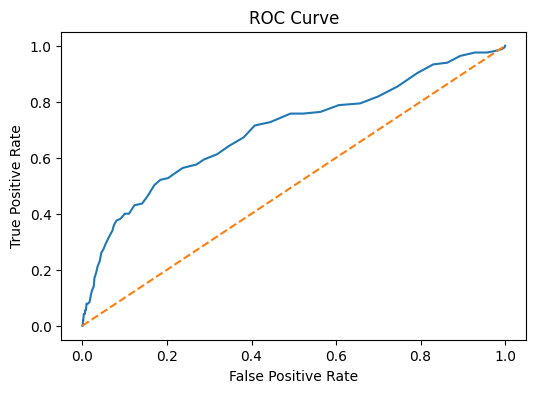

In [219]:
def plot_roc(model_pipe, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    y_proba = model_pipe.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc(rf_model, X, y)


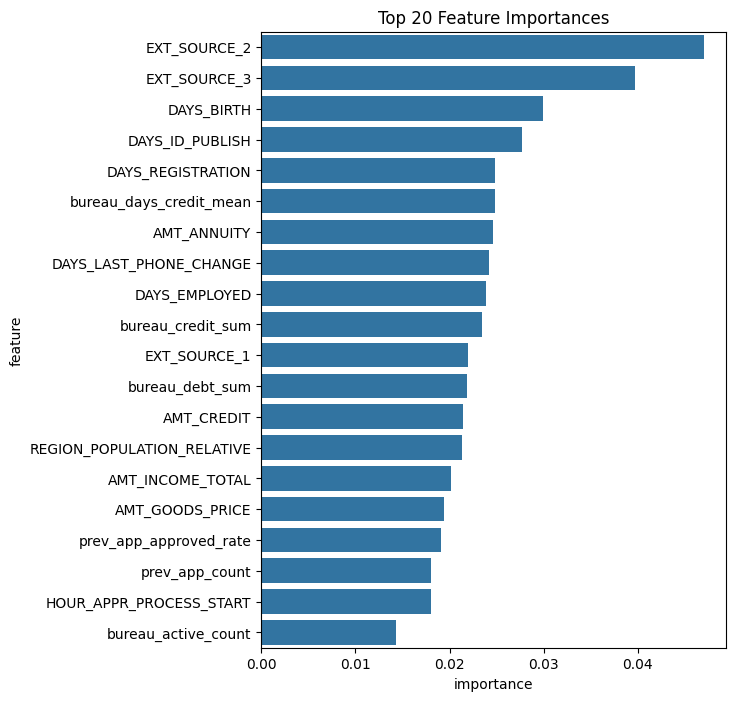

,feature,importance
28,EXT_SOURCE_2,0.047041
29,EXT_SOURCE_3,0.039705
6,DAYS_BIRTH,0.029962
9,DAYS_ID_PUBLISH,0.027747
8,DAYS_REGISTRATION,0.024869


In [220]:
def get_feature_importance(pipe, X):
    clf = pipe.named_steps['clf']
    pre = pipe.named_steps['prep']
    num_names = pre.transformers_[0][2]
    cat_transformer = pre.transformers_[1][1]
    cat_cols = pre.transformers_[1][2]
    ohe = cat_transformer.named_steps['ohe']
    try:
        ohe_cols = list(ohe.get_feature_names_out(cat_cols))
    except:
        ohe_cols = []
    feature_names = list(num_names) + ohe_cols
    if hasattr(clf, 'feature_importances_'):
        fi = clf.feature_importances_
        imp_df = pd.DataFrame({'feature': feature_names, 'importance': fi})
        imp_df = imp_df.sort_values('importance', ascending=False).head(20)
        plt.figure(figsize=(6,8))
        sns.barplot(x='importance', y='feature', data=imp_df)
        plt.title('Top 20 Feature Importances')
        plt.show()
        return imp_df

imp = get_feature_importance(rf_model, X)
imp.head()
